In [49]:
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from itertools import combinations
from wordcloud import WordCloud


# 1. Load Dataset


In [50]:
with open('../data/02_document_search_results.json') as f:
    unique_docs = json.load(f)

# 2. Documents per Year
Evaluate the temporal evolution of articles published over the last years.

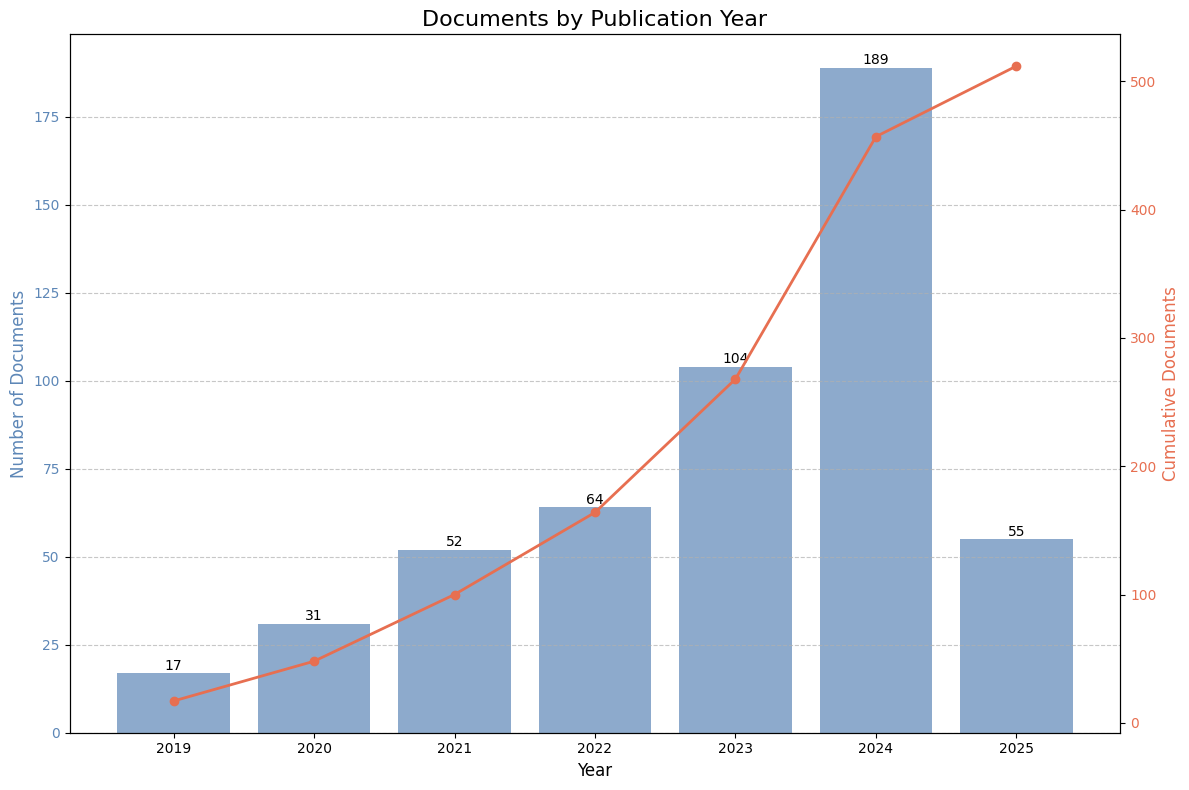

Total documents: 512
Documents with year information: 512
Earliest publication year: 2019
Latest publication year: 2025
Year with most publications: 2024 (189 documents)


In [51]:
# Extract publication years from documents
years = []
for doc in unique_docs:
    if "publication_date" in doc and doc["publication_date"]:
        years.append(doc["publication_date"])

# Count documents per year
year_counts = Counter(years)

# Convert to DataFrame for easier plotting
df_years = pd.DataFrame(list(year_counts.items()), columns=["Year", "Count"])
df_years = df_years.sort_values("Year")

# Create a figure with two y-axes for the bar and line charts
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

# Define matte colors
matte_blue = "#5D87B7"
matte_red = "#E76F51"

# Create bar chart
bars = ax1.bar(df_years["Year"], df_years["Count"], color=matte_blue, alpha=0.7)
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Number of Documents", fontsize=12, color=matte_blue)
ax1.tick_params(axis="y", labelcolor=matte_blue)

# Create line chart showing cumulative documents
df_years["Cumulative"] = df_years["Count"].cumsum()
line = ax2.plot(df_years["Year"], df_years["Cumulative"], marker="o", color=matte_red, linewidth=2)
ax2.set_ylabel("Cumulative Documents", fontsize=12, color=matte_red)
ax2.tick_params(axis="y", labelcolor=matte_red)

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f"{height:.0f}", ha="center", va="bottom")

# Add title and grid
plt.title("Documents by Publication Year", fontsize=16)
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Improve layout
plt.tight_layout()

# Show plot
plt.show()

# Print summary statistics
print(f"Total documents: {len(unique_docs)}")
print(f"Documents with year information: {len(years)}")
print(f"Earliest publication year: {min(years)}")
print(f"Latest publication year: {max(years)}")
print(f"Year with most publications: {year_counts.most_common(1)[0][0]} ({year_counts.most_common(1)[0][1]} documents)")

# 3. Articles per Type
Evaluate the distribution of articles per type.

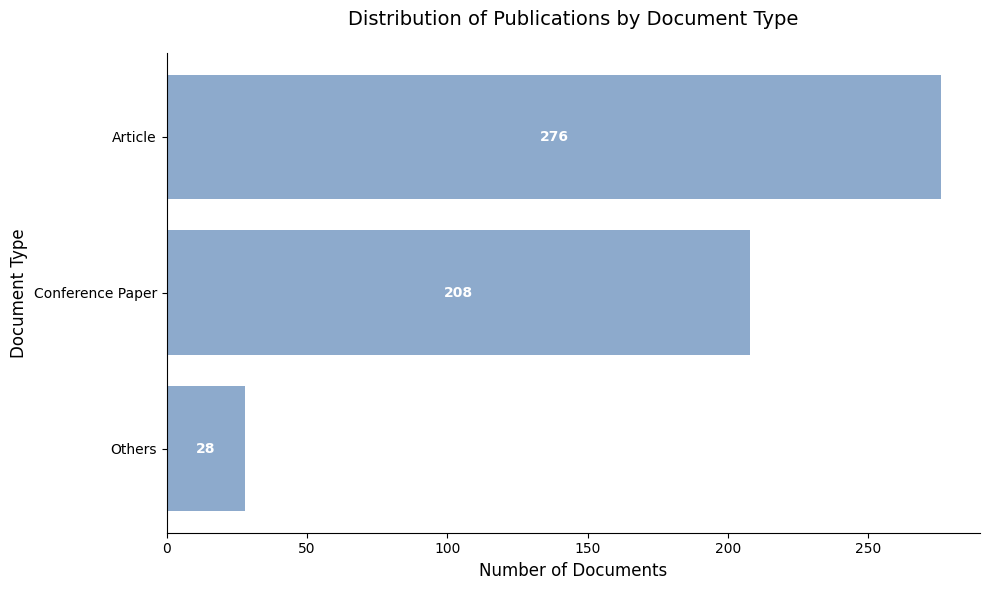

In [52]:
# Filter out retracted titles and group document types
doc_types = []
for doc in unique_docs:
    if "document_type" in doc and "RETRACTED" not in doc.get("title", "").upper():
        doc_type = doc["document_type"]
        if doc_type in ["Article", "Conference Paper"]:
            doc_types.append(doc_type)
        else:
            doc_types.append("Others")

# Count document types
doc_type_counts = Counter(doc_types)

# Convert to DataFrame and sort
df_doc_types = pd.DataFrame(
    list(doc_type_counts.items()), columns=["Document Type", "Count"]
).sort_values(
    "Count", ascending=True
)  # Changed to True for horizontal bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create horizontal bar chart
bars = ax.barh(
    df_doc_types["Document Type"], df_doc_types["Count"], color=matte_blue, alpha=0.7
)

# Add data labels inside the bars
for bar in bars:
    width = bar.get_width()
    ax.text(
        width / 2,  # x position (middle of bar)
        bar.get_y() + bar.get_height() / 2,  # y position (middle of bar)
        f"{int(width):,}",  # formatted number
        ha="center",
        va="center",
        color="white",
        fontweight="bold",
    )

# Customize the plot
ax.set_xlabel("Number of Documents", fontsize=12)
ax.set_ylabel("Document Type", fontsize=12)
ax.set_title("Distribution of Publications by Document Type", fontsize=14, pad=20)

# Remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

# Summary of Subject Areas
Summarize the subject areas of the articles retrieved from the search results.

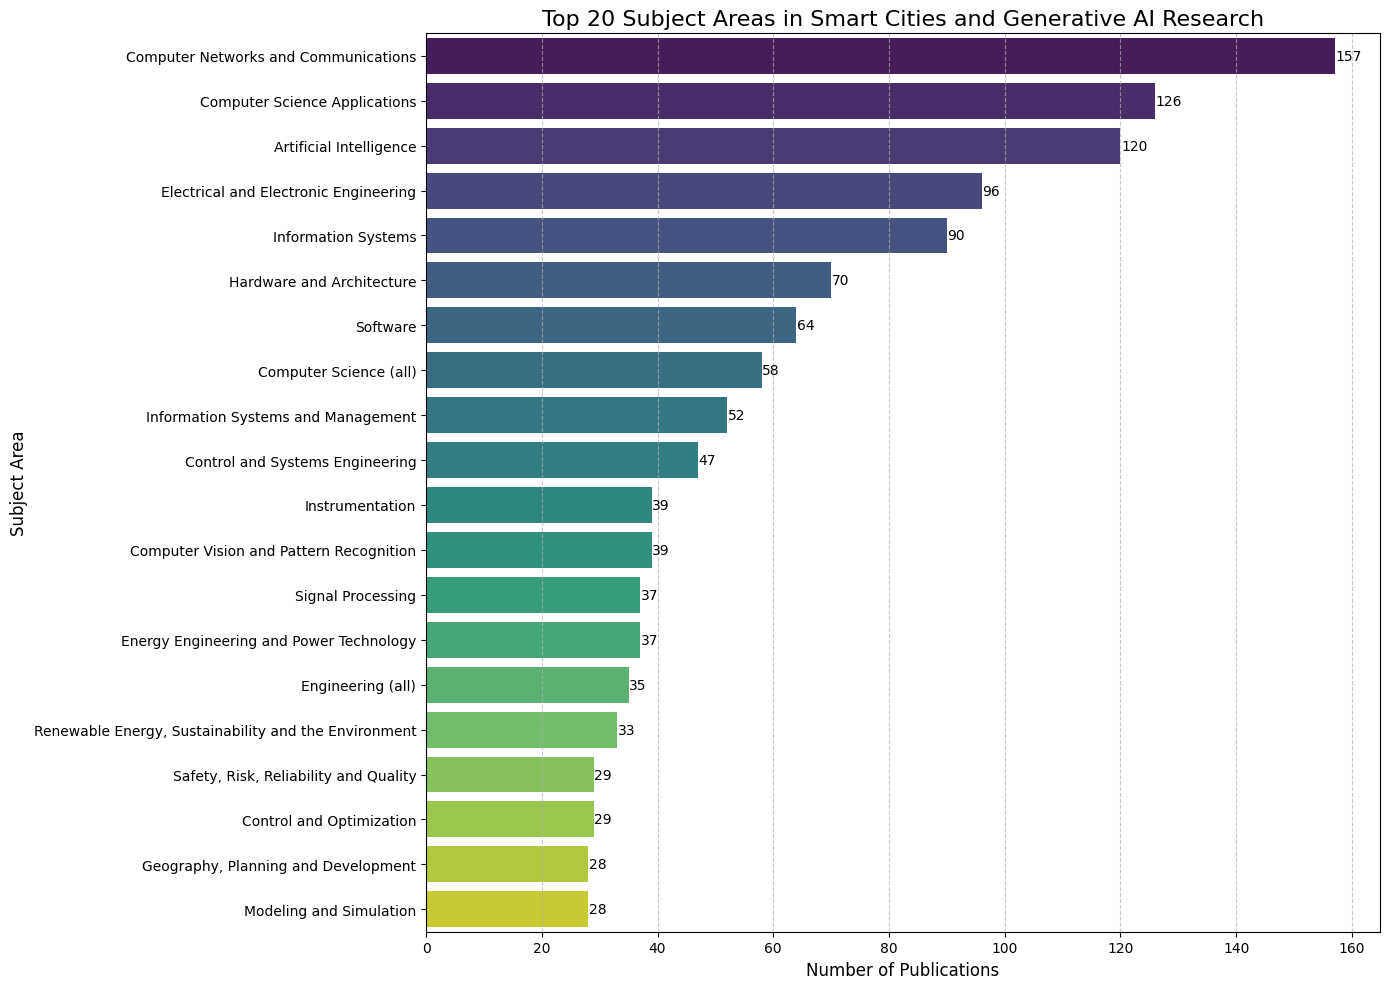



Performing correlation analysis between subject areas...


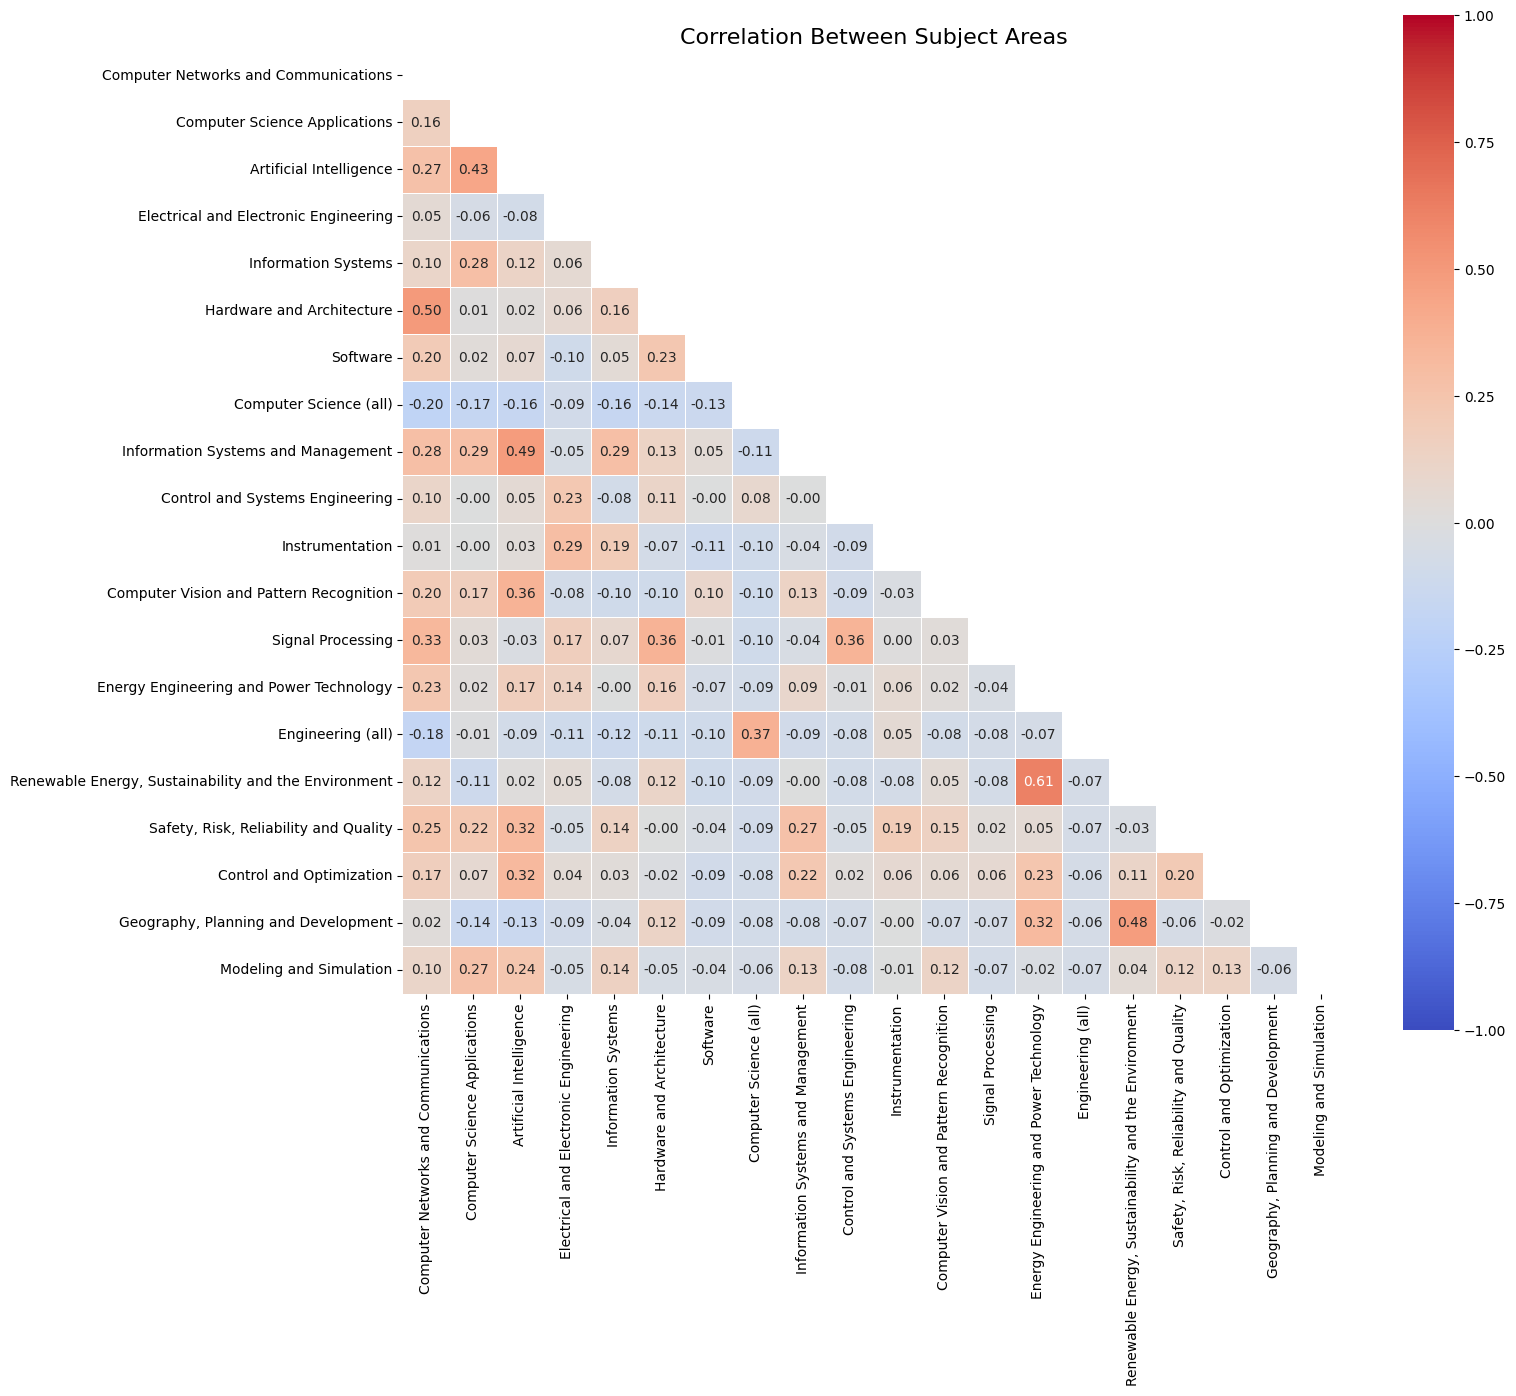


Subject Area Analysis Summary:
Total unique subject areas: 120
Documents with subject area information: 475 out of 512
Average subject areas per document: 3.69

Top 5 most common subject area pairs:
69 - Artificial Intelligence & Computer Science Applications
62 - Artificial Intelligence & Computer Networks and Communications
61 - Computer Networks and Communications & Hardware and Architecture
55 - Computer Networks and Communications & Computer Science Applications
46 - Computer Science Applications & Information Systems


In [53]:
# 1. Extract all subject areas
all_subject_areas = []
subject_area_by_doc = {}

# Iterate through documents to gather subject areas
for i, doc in enumerate(unique_docs):
    if "subject_areas" in doc and doc["subject_areas"]:
        subject_areas = doc["subject_areas"]
        # Store for correlation analysis
        subject_area_by_doc[i] = subject_areas
        # Add to overall list
        all_subject_areas.extend(subject_areas)
        
# Structure the subject areas and save to a file
with open('../data/03_subject_areas.json', 'w') as f:
    json.dump(all_subject_areas, f, indent=2, sort_keys=True)

# Count frequency of each subject area
subject_counts = Counter(all_subject_areas)

# Get top 20 subject areas by frequency
top_subject_areas = subject_counts.most_common(20)

# Create a DataFrame for plotting
df_subjects = pd.DataFrame(top_subject_areas, columns=["Subject Area", "Count"])

# Set up the figure with a larger size
plt.figure(figsize=(14, 10))

# Create a horizontal bar chart
ax = sns.barplot(
    x="Count",
    y="Subject Area",
    hue="Subject Area",
    data=df_subjects,
    palette="viridis",
    legend=False
)

# Customize the plot
plt.title(
    "Top 20 Subject Areas in Smart Cities and Generative AI Research", fontsize=16
)
plt.xlabel("Number of Publications", fontsize=12)
plt.ylabel("Subject Area", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Add counts at the end of each bar
for i, v in enumerate(df_subjects["Count"]):
    ax.text(v + 0.1, i, str(v), va="center")

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

# 2. Subject Area Correlation Analysis
print("\n\nPerforming correlation analysis between subject areas...")

# Create a correlation matrix between subject areas
# First, get unique subject areas from the top 20
unique_areas = [area for area, _ in top_subject_areas]

# Create a document-subject area matrix
doc_subject_matrix = pd.DataFrame(
    0, index=range(len(subject_area_by_doc)), columns=unique_areas
)

# Fill the matrix with 1 where a document has that subject area
for doc_idx, areas in subject_area_by_doc.items():
    for area in areas:
        if area in unique_areas:
            doc_subject_matrix.loc[doc_idx, area] = 1

# Calculate correlation matrix
correlation_matrix = doc_subject_matrix.corr()

# Set up the correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    mask=mask,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
)

plt.title("Correlation Between Subject Areas", fontsize=16)
plt.tight_layout()
plt.show()

# 4. Print summary statistics
print("\nSubject Area Analysis Summary:")
print(f"Total unique subject areas: {len(subject_counts)}")
print(
    f"Documents with subject area information: {len(subject_area_by_doc)} out of {len(unique_docs)}"
)

# Calculate average number of subject areas per document
areas_per_doc = [len(areas) for areas in subject_area_by_doc.values()]
print(
    f"Average subject areas per document: {sum(areas_per_doc)/len(areas_per_doc):.2f}"
)

# Find most common subject area combinations
print("\nTop 5 most common subject area pairs:")
pair_counts = Counter()
for areas in subject_area_by_doc.values():
    for pair in combinations(sorted(areas), 2):
        pair_counts[pair] += 1

for pair, count in pair_counts.most_common(5):
    print(f"{count:2d} - {pair[0]} & {pair[1]}")

In [54]:
import re

# Load the patterns from JSON
with open("../data/keywords_regex.json", "r") as f:
    patterns = json.load(f)

# Add this after loading the JSON to debug patterns
for key, value in patterns.items():
    pattern = value["pattern"]
    try:
        re.compile(pattern)
    except re.error as e:
        print(f"\nError in pattern: {key}")
        print(f"Pattern: {pattern}")
        print(f"Error: {str(e)}")

# Convert to regex mapping dictionary
regex_mapping = {re.compile(p["pattern"]): p["replacement"] for p in patterns.values()}

# Function to normalize keywords using regex
def normalize_keyword_regex(keyword):
    # keyword = keyword.lower().strip()
    keyword = re.sub(r"[^\w\s]", " ", keyword)
    keyword = re.sub(r"\s+", " ", keyword)
    for pattern, replacement in regex_mapping.items():
        if re.search(pattern, keyword):
            return replacement
    return keyword  # return the keyword unchanged if no match

In [55]:
# 1. Extract all keywords with normalization
all_keywords = []
keywords_by_doc = {}
keyword_to_articles = {}

# Iterate through documents to gather keywords
for i, doc in enumerate(unique_docs):
    if "author_keywords" in doc and doc["author_keywords"]:
        # Clean, normalize keywords and group acronyms
        keywords = []
        for kw in doc["author_keywords"]:
            kw_lower = kw.lower().strip()
            normalized_kw = normalize_keyword_regex(kw_lower)
            keywords.append(normalized_kw)  
        # keywords = doc["author_keywords"];

        # Store for correlation analysis
        keywords_by_doc[i] = keywords

        # Add to overall list
        all_keywords.extend(keywords)

        # Track which articles contain each keyword
        for kw in keywords:
            if kw not in keyword_to_articles:
                keyword_to_articles[kw] = []
            keyword_to_articles[kw].append(doc["title"])

# Count frequency of each keyword
keyword_counts = Counter(all_keywords)

print(f"Total unique keywords after normalization: {len(keyword_counts)}")

with open("../data/04_author_keywords_normalized.json", "w") as f:
    json.dump(keyword_counts, f, indent=2, sort_keys=True)

# Get top 50 keywords by frequency
top_keywords = keyword_counts.most_common(50)

Total unique keywords after normalization: 1214


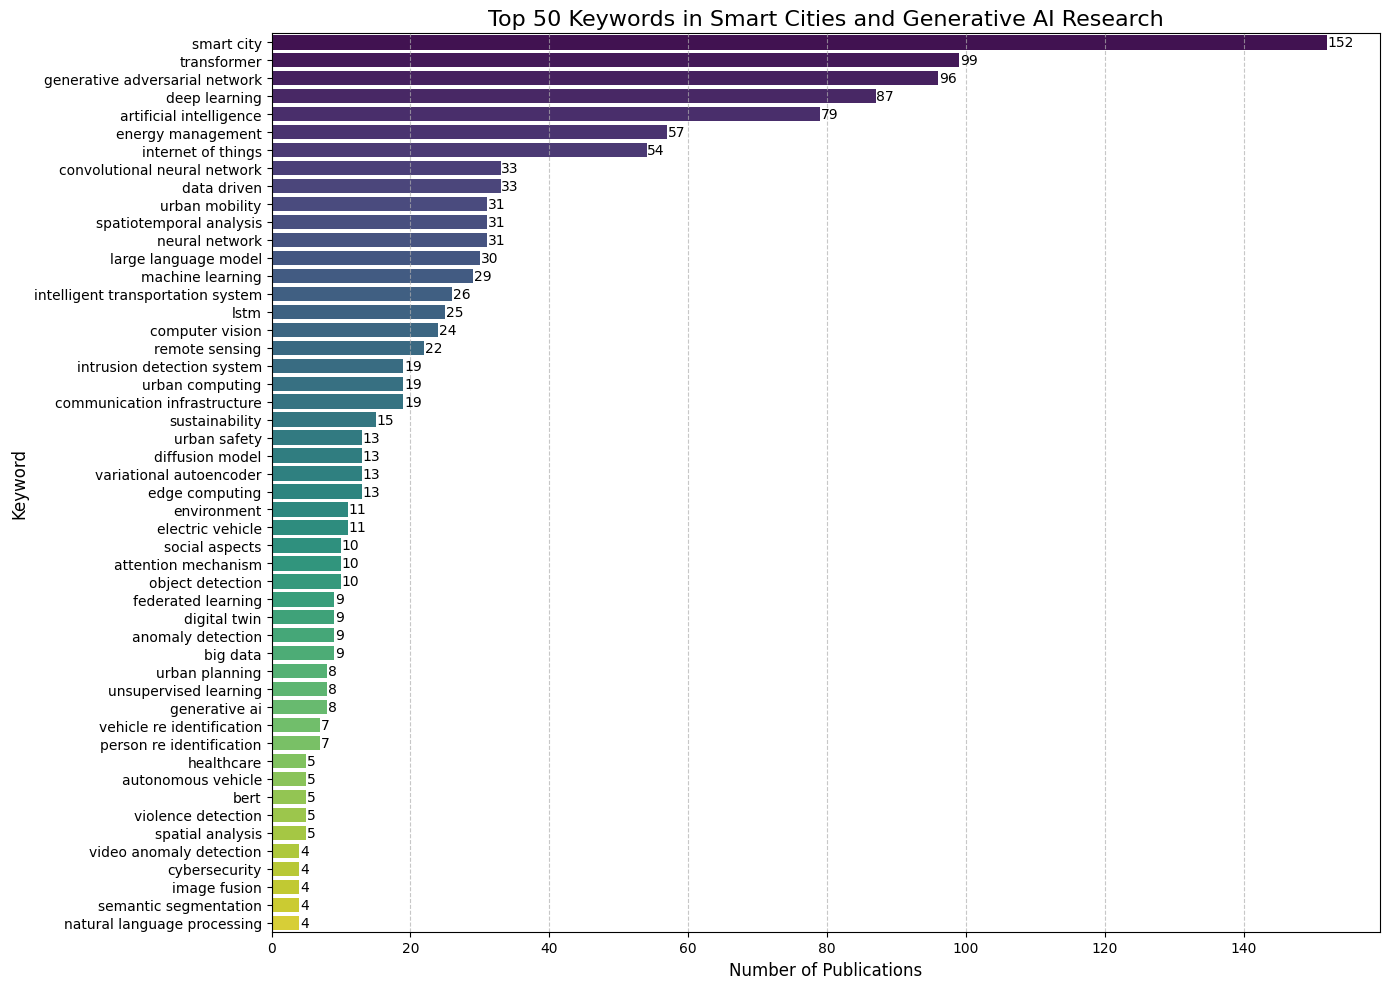

In [77]:
# Create a DataFrame for plotting
df_keywords = pd.DataFrame(top_keywords, columns=["Keyword", "Count"])

# Set up the figure with a larger size
plt.figure(figsize=(14, 10))

# Create a horizontal bar chart
ax = sns.barplot(
    x="Count",
    y="Keyword",
    data=df_keywords,
    hue="Keyword",
    palette="viridis",
    dodge=False,
    legend=False,
)

# Customize the plot
plt.title("Top 50 Keywords in Smart Cities and Generative AI Research", fontsize=16)
plt.xlabel("Number of Publications", fontsize=12)
plt.ylabel("Keyword", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Add counts at the end of each bar
for i, v in enumerate(df_keywords["Count"]):
    ax.text(v + 0.1, i, str(v), va="center")

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

# Save Top50 keywords to a file
with open("../data/05_top_50_keywords.json", "w") as f:
    json.dump(top_keywords, f, indent=2, sort_keys=True)

Classification Results:
category
Technology       31
Application      18
Uncategorized     1
Name: count, dtype: int64


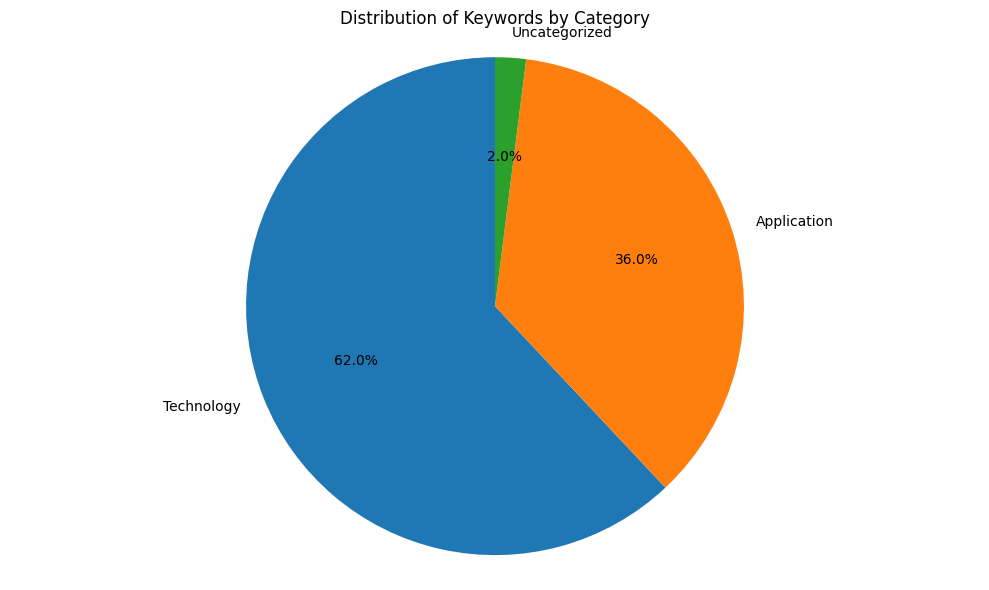

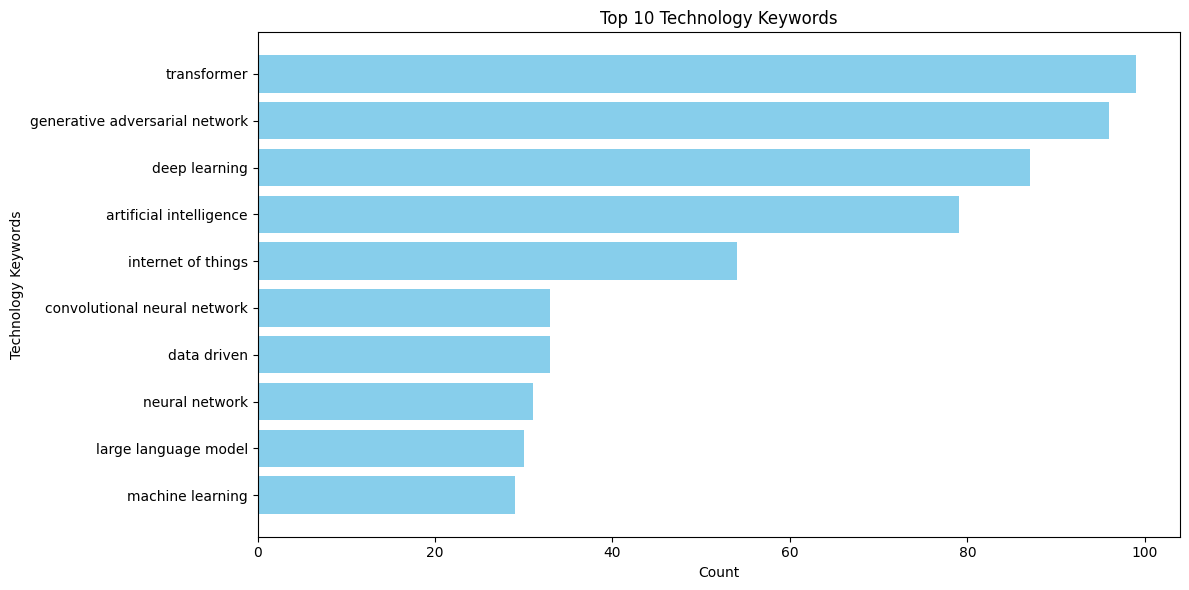

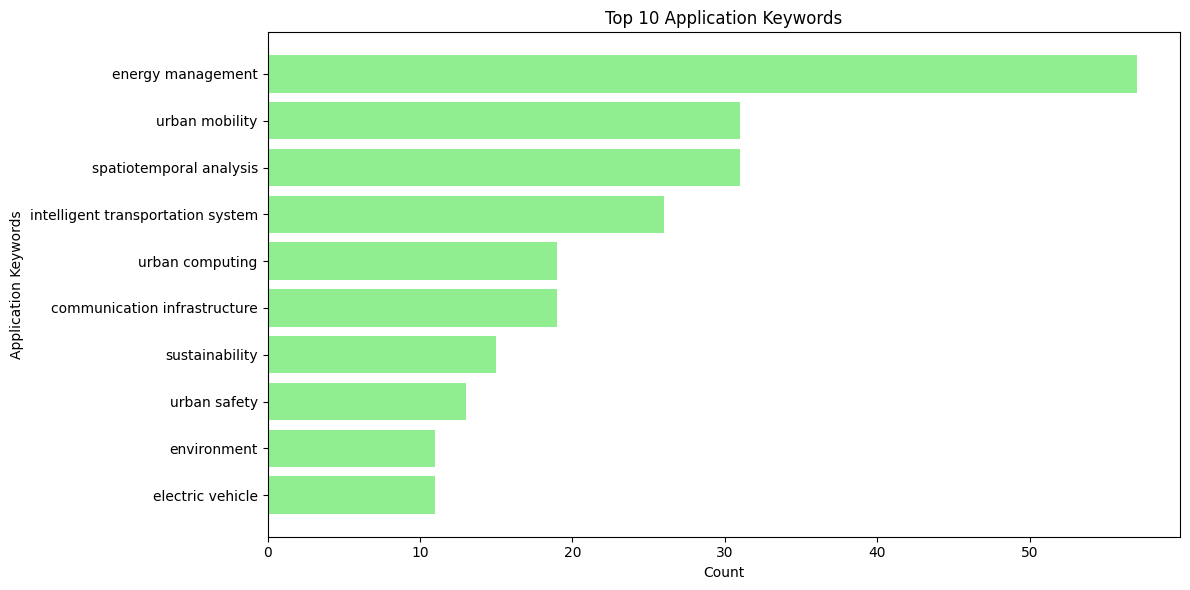

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

# Load the keywords data
with open(
    "/Users/joaocarlos/Developer/Projects/genai-smartcity/data/05_top_50_keywords.json",
    "r",
) as f:
    keywords_data = json.load(f)

# Create a DataFrame
keywords_df = pd.DataFrame(keywords_data, columns=["keyword", "count"])

# Define the classification dictionaries
technology_keywords = [
    "transformer",
    "generative adversarial network",
    "deep learning",
    "artificial intelligence",
    "convolutional neural network",
    "data driven",
    "neural network",
    "large language model",
    "machine learning",
    "lstm",
    "computer vision",
    "remote sensing",
    "intrusion detection system",
    "diffusion model",
    "variational autoencoder",
    "edge computing",
    "attention mechanism",
    "federated learning",
    "digital twin",
    "anomaly detection",
    "big data",
    "unsupervised learning",
    "generative ai",
    "bert",
    "video anomaly detection",
    "image fusion",
    "semantic segmentation",
    "natural language processing",
    "object detection",
    "internet of things",
    "spatial analysis",
]

application_keywords = [
    # "smart city",
    "energy management",
    "urban mobility",
    "spatiotemporal analysis",
    "intelligent transportation system",
    "urban computing",
    "communication infrastructure",
    "sustainability",
    "urban safety",
    "environment",
    "electric vehicle",
    "social aspects",
    "urban planning",
    "vehicle re identification",
    "person re identification",
    "healthcare",
    "autonomous vehicle",
    "violence detection",
    "cybersecurity",
]


# Add a category column to the DataFrame
def categorize_keyword(keyword):
    if keyword in technology_keywords:
        return "Technology"
    elif keyword in application_keywords:
        return "Application"
    else:
        return "Uncategorized"


keywords_df["category"] = keywords_df["keyword"].apply(categorize_keyword)

# Display the classification results
category_counts = keywords_df["category"].value_counts()
print(f"Classification Results:\n{category_counts}")

# Create subsets for technology and application keywords
tech_df = keywords_df[keywords_df["category"] == "Technology"]
app_df = keywords_df[keywords_df["category"] == "Application"]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Distribution of Keywords by Category")
plt.axis("equal")
plt.tight_layout()
plt.show()

# Plot top 10 technology keywords
plt.figure(figsize=(12, 6))
tech_top10 = tech_df.nlargest(10, "count")
plt.barh(tech_top10["keyword"], tech_top10["count"], color="skyblue")
plt.xlabel("Count")
plt.ylabel("Technology Keywords")
plt.title("Top 10 Technology Keywords")
plt.gca().invert_yaxis()  # To have highest count at the top
plt.tight_layout()
plt.show()

# Plot top 10 application keywords
plt.figure(figsize=(12, 6))
app_top10 = app_df.nlargest(10, "count")
plt.barh(app_top10["keyword"], app_top10["count"], color="lightgreen")
plt.xlabel("Count")
plt.ylabel("Application Keywords")
plt.title("Top 10 Application Keywords")
plt.gca().invert_yaxis()  # To have highest count at the top
plt.tight_layout()
plt.show()

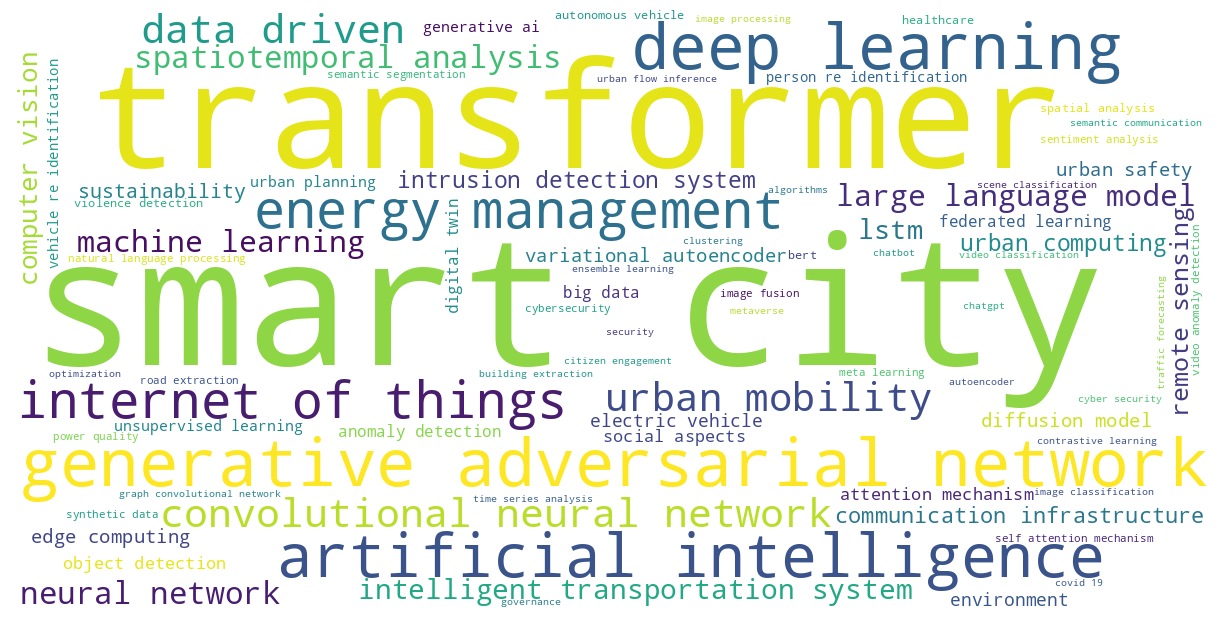

In [57]:
# 2. Generate Word Cloud for visual representation
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=100,
    colormap="viridis",
    min_font_size=10,
).generate_from_frequencies(keyword_counts)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [58]:
# Convert to DataFrame for easier manipulation
df_keywords = pd.DataFrame.from_dict(keyword_counts, orient="index", columns=["count"])
df_keywords = df_keywords.sort_values("count", ascending=False)
df_keywords = df_keywords.reset_index().rename(columns={"index": "keyword"})

# Display the top 20 keywords
print(f"Total unique normalized keywords: {len(df_keywords)}")
df_keywords.head(20)

Total unique normalized keywords: 1214


,keyword,count
0,smart city,152
1,transformer,99
2,generative adversarial network,96
3,deep learning,87
4,artificial intelligence,79
5,energy management,57
6,internet of things,54
7,convolutional neural network,33
8,data driven,33
9,urban mobility,31


In [59]:
def categorize_keywords(keywords_df):
    # Define categories and their related keywords
    categories = {
        "AI/ML Techniques": [
            "artificial intelligence",
            "machine learning",
            "deep learning",
            "neural network",
            "convolutional neural network",
        ],
        "Generative Models": [
            "generative adversarial network",
            "variational autoencoder",
            "diffusion model",
            "generative ai",
        ],
        "Large Language Models": [
            "large language model",
            "retrieval augmented generation",
        ],
        "IoT & Infrastructure": [
            "internet of things",
            "smart grid",
            "edge computing",
            "sensor",
            "blockchain",
        ],
        "Urban Planning": [
            "urban planning",
            "urban computing",
            "urban development",
            "sustainable city",
            "smart city",
        ],
        "Transportation": ["autonomous vehicle", "traffic prediction", "mobility"],
        "Security": [
            "intrusion detection system",
            "cybersecurity",
            "privacy",
            "anomaly detection",
        ],
        "Data Analytics": ["big data", "data mining", "spatial-temporal data mining"],
    }

    # Create a new column for category
    keywords_df["category"] = "Other"

    # Assign categories based on keyword matches
    for category, keywords in categories.items():
        for keyword in keywords:
            keywords_df.loc[
                keywords_df["keyword"].str.contains(keyword, case=False), "category"
            ] = category

    return keywords_df


# Categorize the keywords
df_categorized = categorize_keywords(df_keywords)

# Count keywords by category
category_counts = (
    df_categorized.groupby("category")["count"].sum().sort_values(ascending=False)
)
print(category_counts)

category
Other                    1779
AI/ML Techniques          259
Urban Planning            179
Generative Models         130
IoT & Infrastructure       77
Security                   46
Transportation             37
Large Language Models      31
Data Analytics              9
Name: count, dtype: int64


In [60]:
# 3. Keyword Co-occurrence Analysis
print("\nPerforming keyword co-occurrence analysis...")

# Get unique keywords from the top 40
unique_keywords = [kw for kw, _ in keyword_counts.most_common(40)]

# Create a document-keyword matrix
doc_keyword_matrix = pd.DataFrame(0, index=range(len(keywords_by_doc)), columns=unique_keywords)

# Fill the matrix with 1 where a document has that keyword
for doc_idx, kws in keywords_by_doc.items():
    for kw in kws:
        if kw in unique_keywords:
            doc_keyword_matrix.loc[doc_idx, kw] = 1

# Ensure no missing values and proper type
doc_keyword_matrix = doc_keyword_matrix.fillna(0).astype(int)

# Calculate co-occurrence matrix
cooccurrence_matrix = doc_keyword_matrix.T.dot(doc_keyword_matrix)
np.fill_diagonal(cooccurrence_matrix.values, 0)  # Remove self-co-occurrences

# Print top co-occurring pairs
print("\nTop 10 co-occurring keyword pairs:")
cooccur_pairs = []
for kw1 in unique_keywords:
    for kw2 in unique_keywords:
        if kw1 < kw2:  # To avoid duplicates
            cooccur_pairs.append((kw1, kw2, cooccurrence_matrix.loc[kw1, kw2]))

cooccur_pairs.sort(key=lambda x: x[2], reverse=True)
for kw1, kw2, count in cooccur_pairs[:10]:
    print(f"{kw1} + {kw2}: {count:.0f} co-occurrences")


Performing keyword co-occurrence analysis...

Top 10 co-occurring keyword pairs:
artificial intelligence + smart city: 35 co-occurrences
generative adversarial network + smart city: 26 co-occurrences
deep learning + transformer: 25 co-occurrences
internet of things + smart city: 25 co-occurrences
deep learning + smart city: 22 co-occurrences
smart city + transformer: 21 co-occurrences
convolutional neural network + deep learning: 16 co-occurrences
energy management + smart city: 14 co-occurrences
convolutional neural network + transformer: 14 co-occurrences
large language model + smart city: 14 co-occurrences


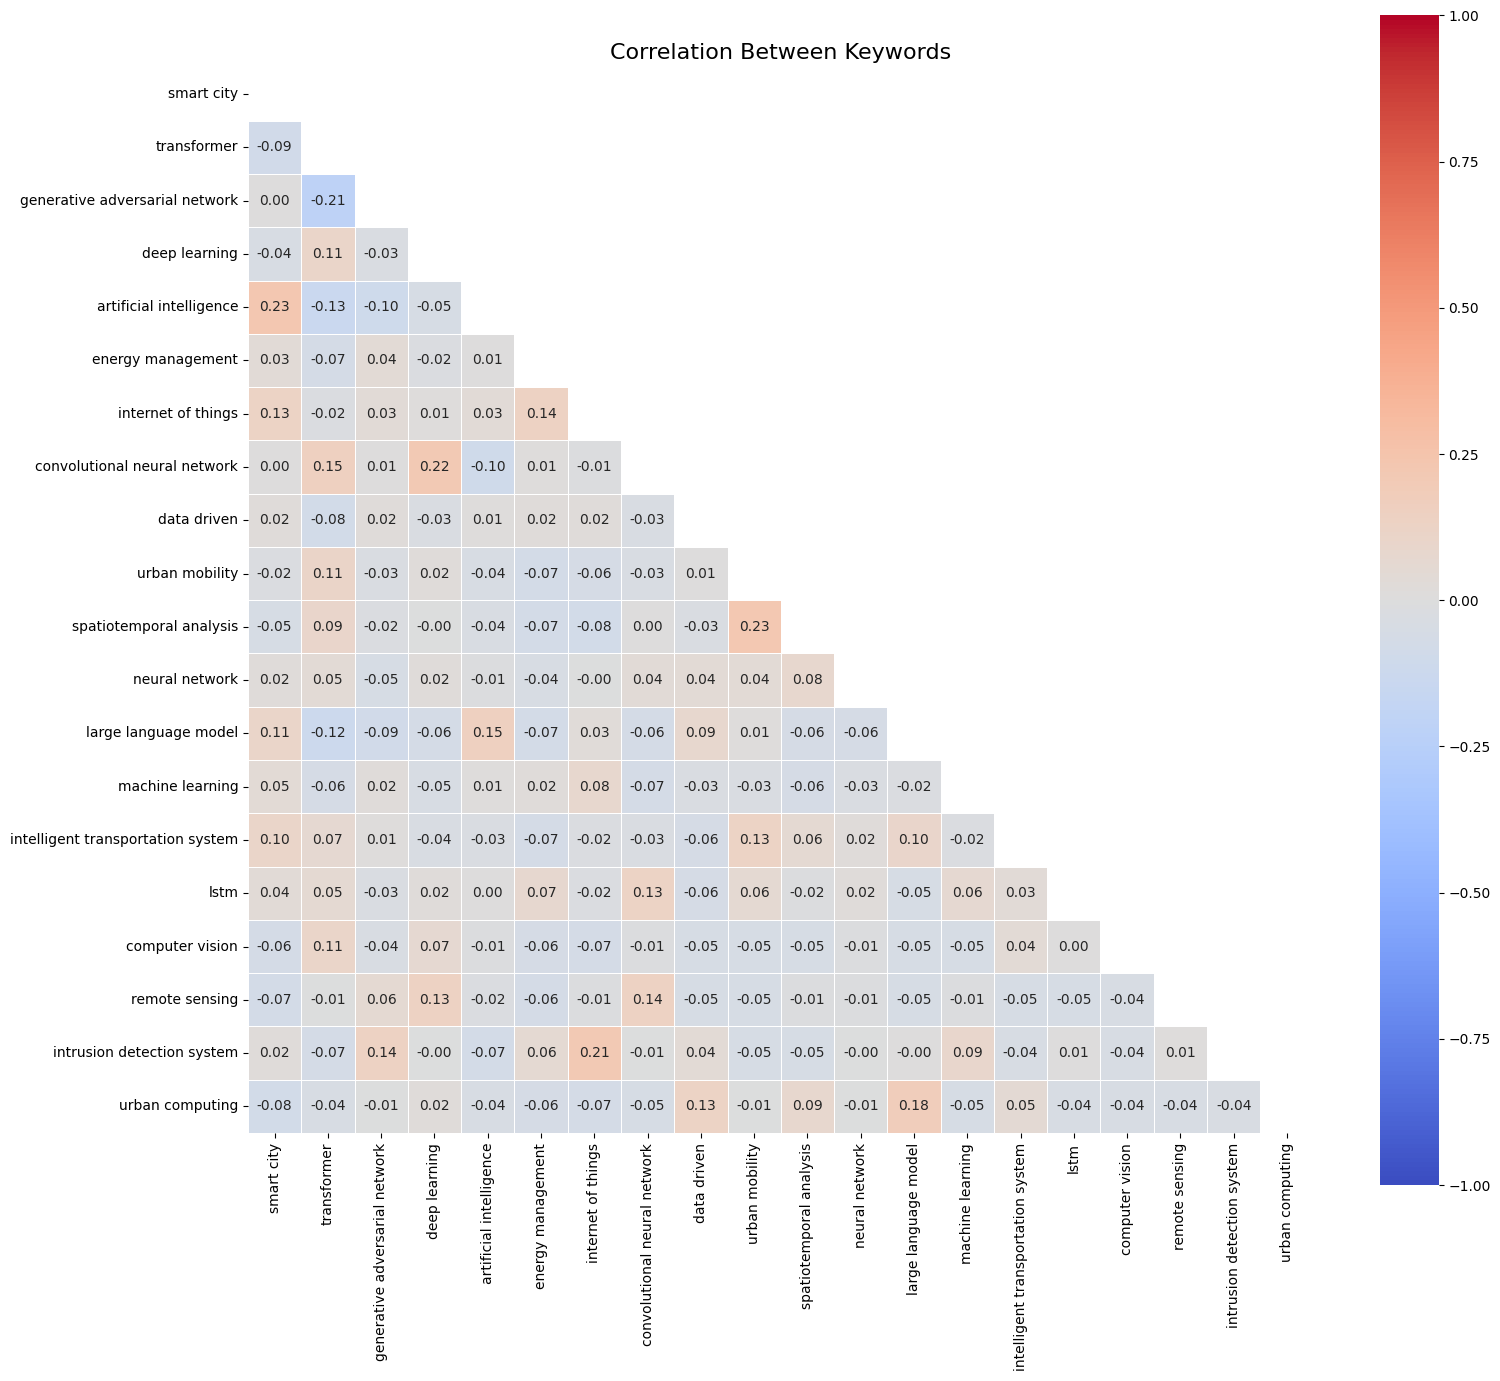

In [61]:
# 4. Correlation Matrix Visualization
# Focus on top 20 keywords for better visualization
top20_keywords = [kw for kw, _ in keyword_counts.most_common(20)]
correlation_matrix = doc_keyword_matrix[top20_keywords].corr()

# Set up the correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    mask=mask,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
)
plt.title("Correlation Between Keywords", fontsize=16)
plt.tight_layout()
plt.show()

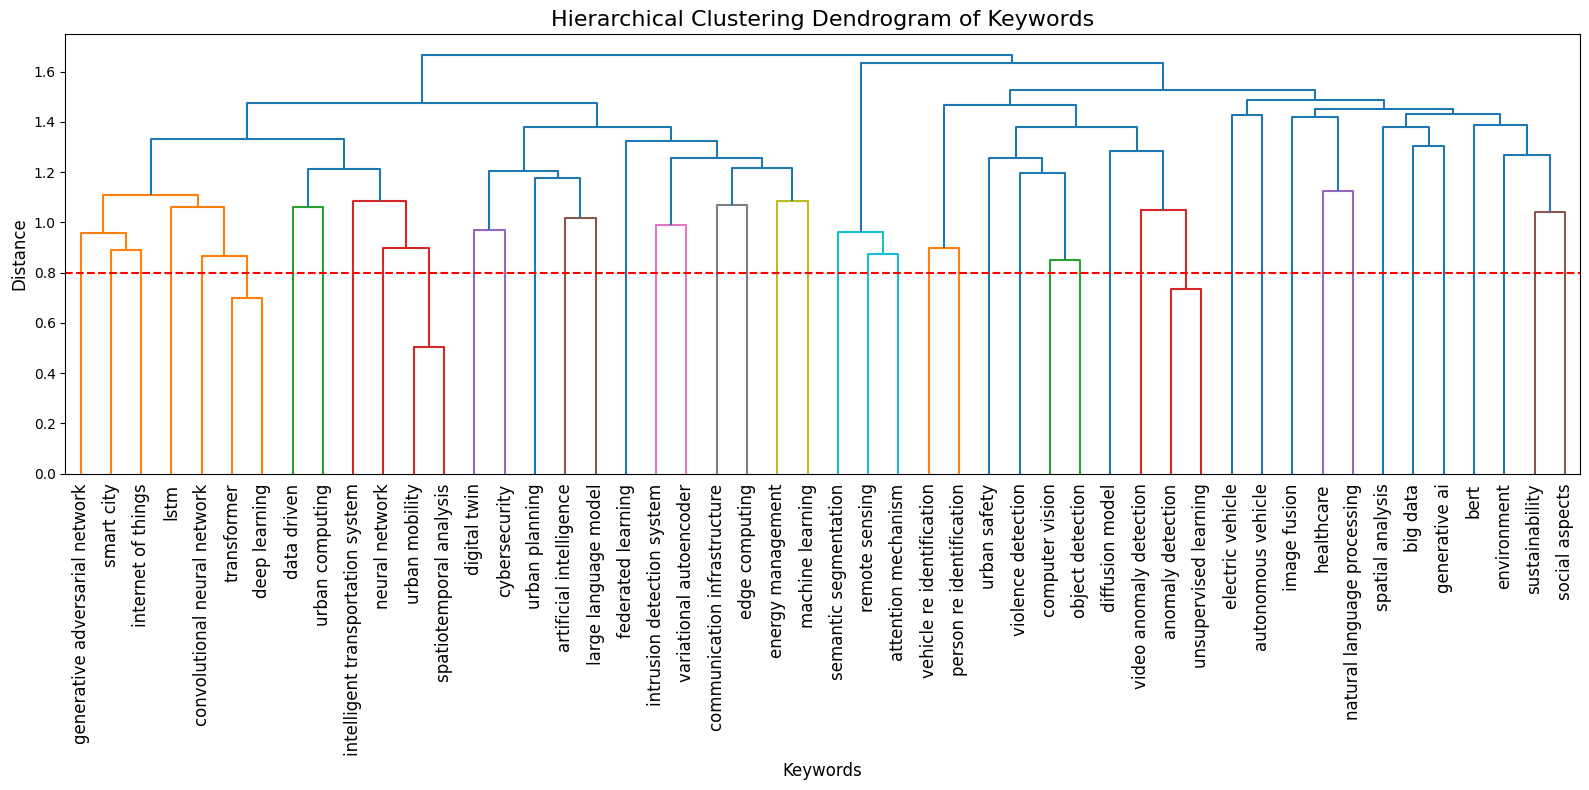


Semantic Keyword Clusters (based on article context):

Cluster 1:
smart city, transformer, generative adversarial network, deep learning, internet of things, convolutional neural network, data driven, urban mobility, spatiotemporal analysis, neural network, intelligent transportation system, lstm, urban computing

Cluster 2:
artificial intelligence, energy management, large language model, machine learning, intrusion detection system, communication infrastructure, variational autoencoder, edge computing, federated learning, digital twin, urban planning, cybersecurity

Cluster 3:
remote sensing, attention mechanism, semantic segmentation

Cluster 4:
vehicle re identification, person re identification

Cluster 5:
computer vision, urban safety, diffusion model, object detection, anomaly detection, unsupervised learning, violence detection, video anomaly detection

Cluster 6:
electric vehicle

Cluster 7:
autonomous vehicle

Cluster 8:
healthcare, natural language processing

Cluster 9:
im

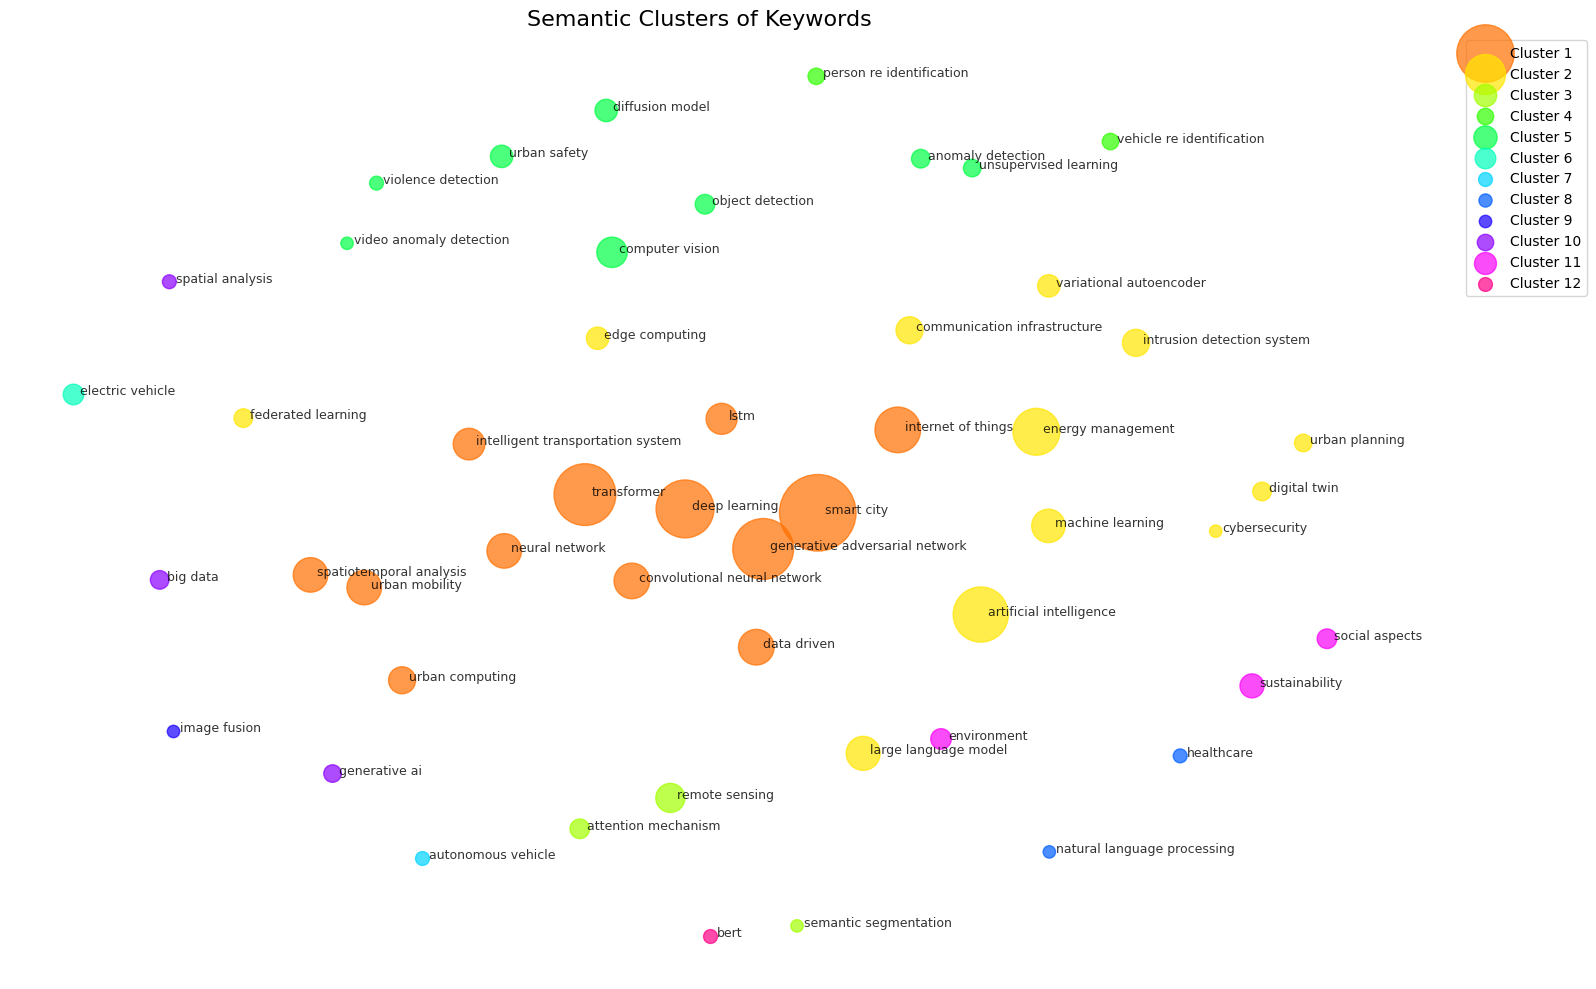



Keyword Cluster Analysis Summary:
Number of clusters: 12

Keywords per cluster:
Cluster 1: 13 keywords
Cluster 2: 12 keywords
Cluster 3: 3 keywords
Cluster 4: 2 keywords
Cluster 5: 8 keywords
Cluster 6: 1 keywords
Cluster 7: 1 keywords
Cluster 8: 2 keywords
Cluster 9: 1 keywords
Cluster 10: 3 keywords
Cluster 11: 3 keywords
Cluster 12: 1 keywords

Top keywords per cluster:
Cluster 1: smart city, transformer, generative adversarial network
Cluster 2: artificial intelligence, energy management, large language model
Cluster 3: remote sensing, attention mechanism, semantic segmentation
Cluster 4: vehicle re identification, person re identification
Cluster 5: computer vision, urban safety, diffusion model
Cluster 6: electric vehicle
Cluster 7: autonomous vehicle
Cluster 8: healthcare, natural language processing
Cluster 9: image fusion
Cluster 10: big data, generative ai, spatial analysis
Cluster 11: sustainability, environment, social aspects
Cluster 12: bert

Average intra-cluster simil

In [74]:
# 6. Semantic Clustering of Keywords
from scipy.cluster.hierarchy import fcluster
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as sch

# Extract the top keywords for clustering
top_kws = [kw for kw, _ in keyword_counts.most_common(50)]

# Create vectors for each keyword based on the articles they appear in
keyword_docs = {}
for kw in top_kws:
    if kw in keyword_to_articles:
        keyword_docs[kw] = " ".join(keyword_to_articles[kw])
    else:
        keyword_docs[kw] = ""

# Vectorize the document text for each keyword
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform([keyword_docs[kw] for kw in top_kws])

# Calculate cosine similarity between keywords
similarity = cosine_similarity(X)

# Convert to a distance matrix for clustering
distance = 1 - similarity

# Perform hierarchical clustering for the dendrogram
linkage = sch.linkage(distance, method="average")

# Determine optimal number of clusters using dendrogram
plt.figure(figsize=(16, 8))
dendrogram = sch.dendrogram(linkage, labels=top_kws, leaf_font_size=12)
plt.title("Hierarchical Clustering Dendrogram of Keywords", fontsize=16)
plt.xlabel("Keywords", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.axhline(y=0.8, color="r", linestyle="--")  # Adjusted threshold for clearer clusters
plt.tight_layout()
plt.savefig("keyword_dendrogram_normalized.png", dpi=300, bbox_inches="tight")
plt.show()

# Choose number of clusters (adjust based on dendrogram)
# num_clusters = 5  # Adjusted based on normalized keywords

# # Perform clustering with average linkage - FIXED PARAMETERS
# clustering = AgglomerativeClustering(
#     n_clusters=num_clusters,
#     metric="precomputed",
#     linkage="average",
# )
# clusters = clustering.fit_predict(distance)
# 6. Semantic Clustering of Keywords - FIXED IMPLEMENTATION
# Choose number of clusters based on dendrogram
num_clusters = 12  # Adjusted based on normalized keywords

# Use the linkage matrix we calculated earlier
clusters = fcluster(linkage, t=num_clusters, criterion="maxclust") - 1

# Create DataFrame with keywords and their clusters
cluster_df = pd.DataFrame(
    {
        "Keyword": top_kws,
        "Cluster": clusters,
        "Frequency": [keyword_counts[kw] for kw in top_kws],
    }
)

# Print the clusters
print("\nSemantic Keyword Clusters (based on article context):")
for i in range(num_clusters):
    cluster_keywords = cluster_df[cluster_df["Cluster"] == i].sort_values(
        "Frequency", ascending=False
    )
    print(f"\nCluster {i+1}:")
    print(", ".join(cluster_keywords["Keyword"].tolist()))

# Create a visualization of the clusters
plt.figure(figsize=(16, 10))

# Set up a color palette for clusters
palette = sns.color_palette("hsv", num_clusters)

# Create a scatter plot for clusters (using MDS for 2D representation)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
positions = mds.fit_transform(distance)

# Plot each cluster
for i in range(num_clusters):
    cluster_mask = clusters == i
    plt.scatter(
        positions[cluster_mask, 0],
        positions[cluster_mask, 1],
        s=[keyword_counts[kw] * 20 for kw in np.array(top_kws)[cluster_mask]],
        c=[palette[i]],
        label=f"Cluster {i+1}",
        alpha=0.7,
    )

# Add labels for each keyword
for i, (keyword, x, y) in enumerate(zip(top_kws, positions[:, 0], positions[:, 1])):
    plt.annotate(
        keyword,
        xy=(x, y),
        xytext=(5, 0),
        textcoords="offset points",
        fontsize=9,
        alpha=0.8,
    )

plt.title("Semantic Clusters of Keywords", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.axis("off")
plt.tight_layout()
plt.savefig("keyword_semantic_clusters_normalized.png", dpi=300, bbox_inches="tight")
plt.show()

# 7. Cluster analysis summary
print("\n\nKeyword Cluster Analysis Summary:")
print(f"Number of clusters: {num_clusters}")

# Count keywords per cluster
cluster_sizes = cluster_df.groupby("Cluster").size().reset_index(name="Count")
print("\nKeywords per cluster:")
for _, row in cluster_sizes.iterrows():
    print(f"Cluster {row['Cluster']+1}: {row['Count']} keywords")

# Get representative keywords for each cluster (top 3 by frequency)
print("\nTop keywords per cluster:")
for i in range(num_clusters):
    top3 = (
        cluster_df[cluster_df["Cluster"] == i]
        .sort_values("Frequency", ascending=False)
        .head(3)
    )
    print(f"Cluster {i+1}: {', '.join(top3['Keyword'].tolist())}")

# Calculate intra-cluster similarity
intra_cluster_sim = []
for i in range(num_clusters):
    cluster_mask = clusters == i
    cluster_indices = np.where(cluster_mask)[0]
    if len(cluster_indices) > 1:
        cluster_sim = 0
        count = 0
        for idx1, idx2 in combinations(cluster_indices, 2):
            cluster_sim += similarity[idx1, idx2]
            count += 1
        if count > 0:
            intra_cluster_sim.append(cluster_sim / count)
        else:
            intra_cluster_sim.append(0)
    else:
        intra_cluster_sim.append(1)

print("\nAverage intra-cluster similarity:")
for i, sim in enumerate(intra_cluster_sim):
    print(f"Cluster {i+1}: {sim:.2f}")

print(
    f"\nOverall average intra-cluster similarity: {sum(intra_cluster_sim)/len(intra_cluster_sim):.2f}"
)

# Suggest cluster themes based on keywords
print("\nSuggested themes for each cluster:")
for i in range(num_clusters):
    cluster_kws = (
        cluster_df[cluster_df["Cluster"] == i]
        .sort_values("Frequency", ascending=False)["Keyword"]
        .tolist()
    )
    top5_kws = cluster_kws[:5]
    print(f"Cluster {i+1}: {', '.join(top5_kws)}")